In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import string
import time
from sklearn import datasets, linear_model
from sklearn import cross_validation, metrics
from nltk.corpus import stopwords
import timeit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from nltk import ngrams
%matplotlib inline
%load_ext cython

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
train[train['is_duplicate']==1]

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
15,15,31,32,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,1
16,16,33,34,What does manipulation mean?,What does manipulation means?,1
18,18,37,38,Why are so many Quora users posting questions ...,Why do people ask Quora questions which can be...,1
20,20,41,42,Why do rockets look white?,Why are rockets and boosters painted white?,1
29,29,59,60,How should I prepare for CA final law?,How one should know that he/she completely pre...,1


In [6]:
#############Prep Train#####################
train=train.fillna('----')
test=test.fillna('----')

In [7]:
stops=stopwords.words("english")
stops = stops + ['']
strPunc=string.punctuation
strPunc =strPunc + '“”'
def simPct(a, b):
    countEq=0
    countTot=0.0000001
    a=a.lower()
    b=b.lower()
    a = ''.join([x for x in a if not x in strPunc])
    b = ''.join([x for x in b if not x in strPunc])
    a = [x for x in a.split(' ') if x not in stops]
    b = [x for x in b.split(' ') if x not in stops]
    for x in a:
        if x in b:
            countEq = countEq + 1
        countTot=countTot+1
    return countEq/countTot

In [8]:
n = 10000
timeit.timeit('simPct("This is a test of a the way that the new thing does stuff. cars","Why does this need to happen like this in this way without having cars made of stell object and other pipes")',number=n, globals=globals())

1.0797730330371509

In [9]:
def pctLikelihood(pct):
    sz0=train[(train['is_duplicate']==0) & (train['simPct']>pct-0.05) & (train['simPct']<pct+0.05)].shape[0]
    sz1=train[(train['is_duplicate']==1) & (train['simPct']>pct-0.05) & (train['simPct']<pct+0.05)].shape[0]
    return sz1/(sz0+sz1)

In [10]:
start = time.time()
train['simPct'] = train.apply(lambda row: 
                              simPct(row['question1'],row['question2'])
                              ,axis=1)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

0 Minute(s), 41 Second(s).


In [11]:
train

,id,qid1,qid2,question1,question2,is_duplicate,simPct
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.857143
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.750000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.333333
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.200000
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,0.500000
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,0.000000
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,0.500000
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,0.500000
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,0.500000


In [12]:
likelihood = pd.DataFrame(columns = {'rdSimPct': [], 'likelihood':[]})
likelihood['rdSimPct']=np.arange(0,1.01,0.01)
likelihood['likelihood']=likelihood.apply(lambda row: pctLikelihood(row['rdSimPct']) ,axis=1)
likelihood['rdSimPct']=likelihood.apply(lambda row: "{0:.2f}".format(row['rdSimPct']),axis=1)

In [13]:
start = time.time()
train['rdSimPct'] = train.apply(lambda row:
                              "{0:.2f}".format(row['simPct'])
                             ,axis=1)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

0 Minute(s), 8 Second(s).


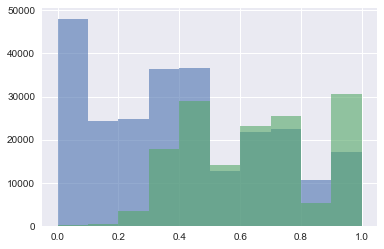

In [14]:
plt.figure(1)
train['simPct'][train['is_duplicate']==0].hist(alpha=0.6)
train['simPct'][train['is_duplicate']==1].hist(alpha=0.6)
plt.show()

In [15]:
regr = linear_model.LinearRegression()

def seriesRegr(X_Series, Y_Series, plot=False):
    npX = X_Series.as_matrix()[:, np.newaxis]
    npY = Y_Series.as_matrix()
    regr.fit(npX, npY)
    if plot:
        # The coefficients
        print('Coefficients: \n', regr.coef_)
        # The mean squared error
        print("Mean squared error: %.2f"
              % np.mean((regr.predict(npX) - npY) ** 2))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % regr.score(npX, npY))

        # Plot outputs
        plt.scatter(npX, npY,  color='black')
        plt.plot(npX, regr.predict(npX), color='blue',
                 linewidth=3)

        plt.xticks(())
        plt.yticks(())

        plt.show()
    return [regr.coef_[0],regr.score(npX, npY)]

def regApply(Season, Team, Years=2):
    select = (trend['Season']>(Season-Years)) & (trend['Season']<=Season) & (trend['team']==Team)
    X_Series = trend['absNum'][select]
    Y_Series = trend['ELO'][select]
    return seriesRegr(X_Series, Y_Series)

Coefficients: 
 [ 0.5698262]
Mean squared error: 0.02
Variance score: 0.62


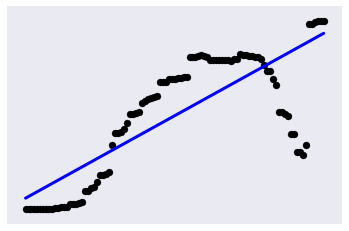

[0.56982619940686152, 0.62164061197391662]

In [16]:
seriesRegr(likelihood.apply(lambda row: float(row['rdSimPct']),axis=1),likelihood['likelihood'],True)

In [17]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,simPct,rdSimPct
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.857143,0.86
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.750000,0.75
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.333333,0.33
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,0.00
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.200000,0.20


In [18]:
train = pd.merge(train,likelihood, on='rdSimPct')
train = train.set_index('id').sort_index()

In [19]:
print("LogLoss Score (Train): %f" % metrics.log_loss(train['is_duplicate'], train['simPct']))

LogLoss Score (Train): 1.222622


In [20]:
train['lenDiff']=train.apply(lambda row: len(row['question1'])/len(row['question2']),axis=1)
train['length']=train.apply(lambda row: len(row['question1']),axis=1)

In [21]:
question = "this is a question example. Here and elephants are quite large"
question = question.lower()
question = ''.join([x for x in question if not x in strPunc]) #change this to RE with punc followed by whitespace
question = [x for x in question.split(' ') if x not in stops]
' '.join(question[0:])


'question example elephants quite large'

In [22]:
start = time.time()
#test_qs=pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
#train_qs=train_qs.append(test_qs)
counter=0
gDict = {}
maxGram=5
for i in range(1,maxGram+1):
    gDict[i]={}
for row in train_qs:
    question = row
    question = question.lower()
    question = ''.join([x for x in question if not x in strPunc]) #change this to RE with punc followed by whitespace
    question = [x for x in question.split(' ') if x not in stops]
    for i in range(1,maxGram+1):
        for count in range(0,len(question)-(i-1)):
            phrase = ' '.join(question[count:count+i])
            if phrase in gDict[i]:
                gDict[i][phrase] = gDict[i][phrase] + 1
            else:
                gDict[i][phrase] = 1

                
#print(counter)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

0 Minute(s), 50 Second(s).


In [23]:
np.log10(10)

1.0

In [24]:
gDict[1]

{'maxentropy': 1,
 'bettman': 1,
 'medtech': 1,
 'brotherels': 1,
 '200ah': 22,
 'weirdestgrossestmost': 1,
 'noncoder': 4,
 'likeliest': 1,
 'polarcovalent': 1,
 'clippersbloggers': 2,
 'inthe': 1,
 'acceptanceindifferencebelief': 2,
 'sm': 46,
 'bean': 61,
 'faa': 2,
 'onfinishalert': 1,
 'subadar': 1,
 'servicemen': 6,
 'kodak': 10,
 'noncombat': 2,
 'falsifies': 1,
 'spaniards': 20,
 'leatherworking': 3,
 'psychic': 61,
 'smithmine': 1,
 'parcells': 1,
 'from7': 1,
 'lawlessness': 1,
 'armenian': 48,
 'lancher': 1,
 'adhaar': 11,
 'crucial': 41,
 'colliecatahoula': 1,
 'ponty': 1,
 'patrikacom': 2,
 '39k': 1,
 'orienter': 1,
 'carlsen': 24,
 'topicsproblems': 1,
 'bitte': 1,
 'lambdadelta': 1,
 'dreadnought': 3,
 'apporach': 2,
 'copa': 22,
 'diffrences': 2,
 'piracetam': 5,
 'gellmann': 1,
 'haflong': 1,
 'themed': 32,
 '030412now': 1,
 '200s': 4,
 'kalpetta': 2,
 'khq': 1,
 'h264': 3,
 'bestfriend': 20,
 'liberalisation': 5,
 'blogss': 1,
 'zwoorcom': 1,
 'sumans': 1,
 'sexual': 

In [25]:
avDict={}

sum([gDict[1][key] for key in gDict[1]])/len([gDict[1][key] for key in gDict[1]])

40.64322108292533

In [73]:
np.sqrt(4)

2.0

In [74]:
weights={}
for i in range(1,maxGram+1):
    weights[i] = dict((k, 1/np.sqrt(v)) for k, v in gDict[i].items() if v>1)
    #weights[i] = dict((k, 1/np.log(v)) for k, v in gDict[i].items() if v>1)

In [75]:
print('Most common words and weights: \n')
print(sorted(weights[1].items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights[1].items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('best', 0.0037665117385776454), ('get', 0.0050306546248321694), ('india', 0.0059028133610095519), ('people', 0.0061938802487512207), ('like', 0.0062629797753490568), ('good', 0.0063542353735870569), ('would', 0.0065120674599502609), ('one', 0.0071908957613184303), ('make', 0.0074194266399600717), ('way', 0.0074436416771926708)]

Least common words and weights: 


[('renders', 0.70710678118654746),
 ('mfe', 0.70710678118654746),
 ('clippersbloggers', 0.70710678118654746),
 ('faa', 0.70710678118654746),
 ('dmw', 0.70710678118654746),
 ('noncombat', 0.70710678118654746),
 ('patrikacom', 0.70710678118654746),
 ('polysemy', 0.70710678118654746),
 ('consul', 0.70710678118654746),
 ('apporach', 0.70710678118654746)]

In [28]:
train

,qid1,qid2,question1,question2,is_duplicate,simPct,rdSimPct,likelihood,lenDiff,length
id,,,,,,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.857143,0.86,0.334853,1.157895,66
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.750000,0.75,0.529446,0.579545,51
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.333333,0.33,0.277708,1.237288,73
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,0.00,0.002705,0.769231,50
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.200000,0.20,0.062557,1.948718,76
5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,0.500000,0.50,0.450084,0.955556,86
6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,0.000000,0.00,0.002705,0.306452,19
7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,0.500000,0.50,0.450084,0.731707,30
8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,0.500000,0.50,0.450084,0.837838,31


In [29]:
a,b=train.loc[0,'question1'],train.loc[0,'question2']

In [30]:
g=1
a,b=train.loc[0,'question1'],train.loc[0,'question2']
a,b=a.lower(),b.lower()
a=''.join([x for x in a if not x in strPunc])
b=''.join([x for x in b if not x in strPunc])
a,b=a.split(),b.split()
a=[x for x in a if x not in stops]
b=[x for x in b if x not in stops]
a=[' '.join(a[i:i+g]) for i in range(len(a)-g+1)]
b=[' '.join(b[i:i+g]) for i in range(len(b)-g+1)]
a=list(set(a))
b=list(set(b))
num=np.sum([weights[g].get(x,0) for x in a if x in b])+np.sum([weights[g].get(x,0) for x in b if x in a])
den=np.sum([weights[g].get(x,0) for x in a])+np.sum([weights[g].get(x,0) for x in b])
num/den

0.93756567063907326

In [31]:
a.count('laugh')

0

In [32]:
a,b="one two three four","one two three four five"
print(a)
print(b)

one two three four
one two three four five


In [76]:
def genGram(a,b,g=1):
    a,b=a.lower(),b.lower()
    a=''.join([x for x in a if not x in strPunc])
    b=''.join([x for x in b if not x in strPunc])
    a,b=a.split(),b.split()
    a=[x for x in a if x not in stops]
    b=[x for x in b if x not in stops]
    a=[' '.join(a[i:i+g]) for i in range(len(a)-g+1)]
    b=[' '.join(b[i:i+g]) for i in range(len(b)-g+1)]
    a=list(set(a))
    b=list(set(b))
    num=np.sum([1 for x in a if x in b])+np.sum([1 for x in b if x in a])
    den=len(a)+len(b)
    return num/den


def genGramTFIDF(a,b,g=1): #WIP
    a,b=a.lower(),b.lower()
    a=''.join([x for x in a if not x in strPunc])
    b=''.join([x for x in b if not x in strPunc])
    a,b=a.split(),b.split()
    a=[x for x in a if x not in stops]
    b=[x for x in b if x not in stops]
    a=[' '.join(a[i:i+g]) for i in range(len(a)-g+1)]
    b=[' '.join(b[i:i+g]) for i in range(len(b)-g+1)]
    #a=list(set(a))
    #b=list(set(b))
    num=np.sum([b.count(x)*weights[g].get(x,0)**2 for x in a if x in b])
    den = (np.linalg.norm(np.array([weights[g].get(x,0) for x in a]))*
        np.linalg.norm(np.array([weights[g].get(x,0) for x in b]))
       )
    return num,den,num/den

In [66]:
genGramTFIDF(a,b)

(0.069400937283604233, 0.080991186497678613, 0.85689493245778559)

In [67]:
timeit.timeit("genGramTFIDF(train.loc[0,'question1'],train.loc[0,'question2'],1)",number=1000, globals=globals())

KeyError: 'the label [0] is not in the [index]'

In [36]:
train=train.sample(40000)

In [68]:
start = time.time()
for i in range(1,maxGram+1):
    train['GramPct'+str(i)]= train.apply(lambda row: genGram(row['question1'],row['question2'],i),axis=1)
    print(i)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars


1
2
3
4
5
0 Minute(s), 29 Second(s).


In [38]:
train

,qid1,qid2,question1,question2,is_duplicate,simPct,rdSimPct,likelihood,lenDiff,length,GramPct1,GramPct2,GramPct3,GramPct4,GramPct5
id,,,,,,,,,,,,,,,
117372,190983,190984,"What does ""virtually"" mean?",What is virtualizer?,0,0.000000,0.00,0.002705,1.350000,27,0.000000,0.000000,NaN,NaN,NaN
393079,156339,525834,Who was the Japanese actress that offered to m...,Whatever happened to actress Jewel Blanch?,0,0.272727,0.27,0.123054,3.380952,142,0.375000,0.142857,0.000000,0.000000,0.000000
78366,133644,133645,"If you get free food, shelter and clothing wil...",If you were the last survivor on earth..what w...,0,0.333333,0.33,0.277708,0.446154,58,0.250000,0.000000,0.000000,0.000000,0.000000
135052,215749,215750,Why do some white actors look slightly darker ...,What are the features of Magneto Mall of Raipu...,0,0.000000,0.00,0.002705,1.295455,114,0.000000,0.000000,0.000000,0.000000,0.000000
311746,91082,7224,What are the best books for preparation for CAT?,What are the section-wise best books to prepar...,1,0.750000,0.75,0.529446,0.857143,48,0.666667,0.285714,0.000000,0.000000,0.000000
93182,155858,155859,"Is the slogan ""Make America Hate Again"" a fair...","Is the slogan ""Make America Hate Again"" a fair...",1,0.916667,0.92,0.196685,1.049180,128,0.916667,0.909091,0.900000,0.888889,0.875000
314035,438694,438695,What are the top ten must-see attractions in A...,"What are the top 10 must-see places, sights & ...",1,0.600000,0.60,0.530802,0.716216,53,0.500000,0.000000,0.000000,0.000000,0.000000
126720,204166,204167,What is the best and fastest way to get review...,How can I get reviews on Amazon on new product...,0,0.428571,0.43,0.389200,0.922078,71,0.428571,0.307692,0.181818,0.000000,0.000000
342998,267544,471061,Why do some Americans vote only Democratic or ...,"As a Republican, I'd vote for a Democrat if?",0,0.181818,0.18,0.023135,2.954545,130,0.266667,0.000000,0.000000,0.000000,0.000000


In [77]:
start = time.time()
for i in range(1,maxGram+1):
    (train['GIDFNum'+str(i)],train['GIDFDen'+str(i)],train['GIDF'+str(i)])= \
    zip(*train.apply(lambda row: genGramTFIDF(row['question1'],row['question2'],i),axis=1))
    print(i)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: invalid value encountered in double_scalars


1
2
3
4
5
0 Minute(s), 40 Second(s).


In [40]:
def normalizer(num):
    return num**(1/25)

In [41]:
start = time.time()
#train['threeGIDF']= train.apply(lambda row: threeGramTFIDF(row['question1'],row['question2']),axis=1)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

0 Minute(s), 0 Second(s).


In [42]:
train['pctPos']=train.apply(lambda row: 0.165, axis=1)

In [43]:
target='is_duplicate'

In [44]:
list(train)

['qid1',
 'qid2',
 'question1',
 'question2',
 'is_duplicate',
 'simPct',
 'rdSimPct',
 'likelihood',
 'lenDiff',
 'length',
 'GramPct1',
 'GramPct2',
 'GramPct3',
 'GramPct4',
 'GramPct5',
 'GIDFNum1',
 'GIDFDen1',
 'GIDF1',
 'GIDFNum2',
 'GIDFDen2',
 'GIDF2',
 'GIDFNum3',
 'GIDFDen3',
 'GIDF3',
 'GIDFNum4',
 'GIDFDen4',
 'GIDF4',
 'GIDFNum5',
 'GIDFDen5',
 'GIDF5',
 'pctPos']

In [45]:
predictors = [x for x in list(train) if x not in ['id','qid1','qid2','question1','question2','is_duplicate','rdSimPct']]

In [46]:
#predictors=['GIDF1','GramPct1']

In [47]:
train[predictors+['is_duplicate']]

,simPct,likelihood,lenDiff,length,GramPct1,GramPct2,GramPct3,GramPct4,GramPct5,GIDFNum1,...,GIDFDen3,GIDF3,GIDFNum4,GIDFDen4,GIDF4,GIDFNum5,GIDFDen5,GIDF5,pctPos,is_duplicate
id,,,,,,,,,,,,,,,,,,,,,
117372,0.000000,0.002705,1.350000,27,0.000000,0.000000,NaN,NaN,NaN,0.000000,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.165,0
393079,0.272727,0.123054,3.380952,142,0.375000,0.142857,0.000000,0.000000,0.000000,0.089761,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.165,0
78366,0.333333,0.277708,0.446154,58,0.250000,0.000000,0.000000,0.000000,0.000000,0.090126,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.165,0
135052,0.000000,0.002705,1.295455,114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.165,0
311746,0.750000,0.529446,0.857143,48,0.666667,0.285714,0.000000,0.000000,0.000000,0.038455,...,1.272935,0.000000,0.000000,1.204926,0.000000,0.000000,0.000000,NaN,0.165,1
93182,0.916667,0.196685,1.049180,128,0.916667,0.909091,0.900000,0.888889,0.875000,0.809775,...,17.479487,1.000000,16.650952,16.650952,1.000000,14.569583,14.569583,1.000000,0.165,1
314035,0.600000,0.530802,0.716216,53,0.500000,0.000000,0.000000,0.000000,0.000000,0.132566,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.165,1
126720,0.428571,0.389200,0.922078,71,0.428571,0.307692,0.181818,0.000000,0.000000,0.081024,...,0.900588,0.919994,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.165,0
342998,0.181818,0.023135,2.954545,130,0.266667,0.000000,0.000000,0.000000,0.000000,0.047705,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.165,0


In [85]:
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train[predictors], train[target], test_size=0.2, random_state=4242)

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.1
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.658193	valid-logloss:0.657737
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.497265	valid-logloss:0.495157
[20]	train-logloss:0.449156	valid-logloss:0.447948
[30]	train-logloss:0.429387	valid-logloss:0.428992
[40]	train-logloss:0.418636	valid-logloss:0.419932
[50]	train-logloss:0.411931	valid-logloss:0.414326
[60]	train-logloss:0.406024	valid-logloss:0.410498
[70]	train-logloss:0.40226	valid-logloss:0.408502
[80]	train-logloss:0.398229	valid-logloss:0.405915
[90]	train-logloss:0.395157	valid-logloss:0.404362
[100]	train-logloss:0.39248	valid-logloss:0.403062
[110]	train-logloss:0.389738	valid-logloss:0.40187
[120]	train-logloss:0.387072	valid-logloss:0.400677
[130]	train-logloss:0.385578	valid-logloss:0.40017
[140]	train-logloss:0.383333	valid-logloss:0.399208
[150]	train-logloss:0.381333	valid-logloss:0.398724
[160]	train-logloss:0.378976	val

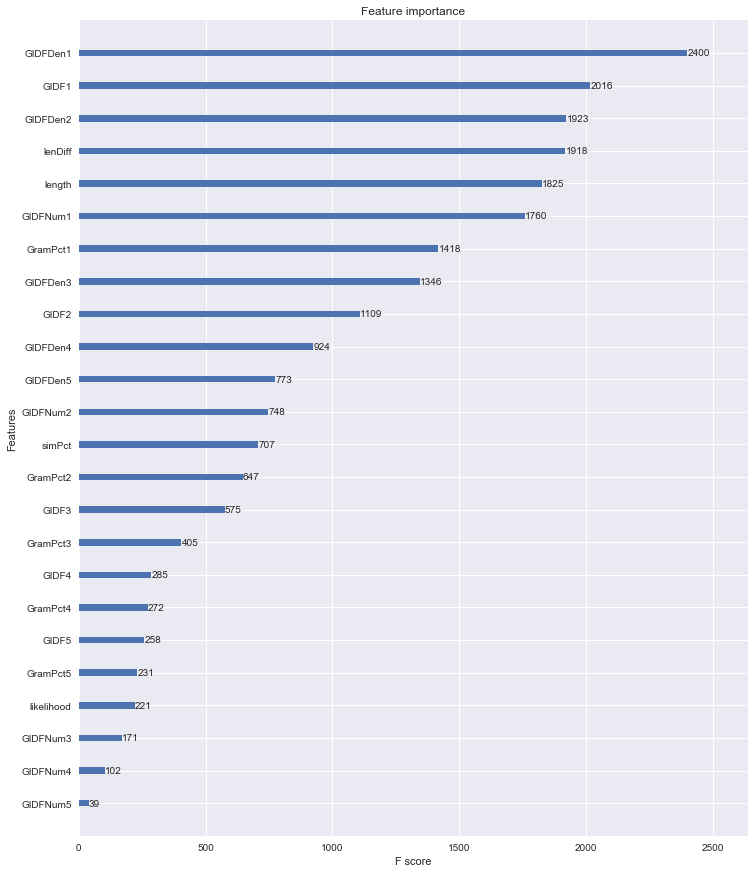

In [72]:
plt.rcParams['figure.figsize'] = (12.0, 15.0)
xgb.plot_importance(bst); plt.show()

In [1]:
#New Set, only GIDF1 and oneGPct: 0.526645
#Total re-up with all attributes: 0.450352
#removing punctuation: 0.491681
#setting to 10k eps: 0.492241
#Using new norm: 0.492103
#Removing uniqueness: 0.492353
#adding up to 5-grams: 0.425592
#Switching to Cosine with num and den: 0.386617
#md = 5: 0.380441
#md=7: 0.374092

##########################################################
#word match: 0.533386
#lenDiff: 0.51879
#+length: 0.51078
#+2-gram ct&pct
#+3-gram ct&pct: 0.500387
#ETA to 0.3: 0.498744
#+Basic IDF: 0.488933
#+proportionality norm vector: 0.485098
#+2-gram IDF: 0.476334
#+3-gram IDF: 0.476334
#+eps: 0.451873
#+Increasing eps: 0.435362
#+Increasing eps: 0.433209
#+3-gram for real this time: 0.424584

#Eps reset: 0.428649
#Upping to 10k eps: 0.418711
#removing 1000 dividend, limiting divisor eps to 100: 0.445081
#increasing eps back to 10000: 0.418711 #Pretty much expected
#increasing eps to 100k: 0.417037
#normalizing metric with **(1/25): 0.417037... does this mean it already transformed it, and this wasn't needed?
#Adding 4&5 grams: 0.42157...why did it get worse? Because I left so many vars in
#removing excess vars: 0.411745
#increasing trees to 7: 0.413171
#decreasing trees to 3: 0.416839
#back to 5 trees, lr of 0.2 from 0.3: 0.410837
#further decreasing to 0.1: 0.417812
#up to 0.15: 0.415507
#up to 0.25: 0.415581
#back to 0.2: 0.410837
#Changed norm to length avg: ~0.418
#Back to norm norm: 0.410873
#0.02 eta and md = 4: 0.441539
#reverting: 0.410873
#Adding eps to norm: 


#Changing to eta=0.7, md=5, rounds=100: 0.417584

#before eps: 0.554686
#after eps: 0.522193

In [50]:
notafunc

NameError: name 'notafunc' is not defined

In [ ]:
plt.figure(1)
curr=1
train[(train['is_duplicate']==0)&(train['GIDF'+str(curr)]>0)].apply(lambda row: row['GIDF'+str(curr)]**(1/1),axis=1).hist(alpha=0.6,bins=20)
train[(train['is_duplicate']==1)&(train['GIDF'+str(curr)]>0)].apply(lambda row: row['GIDF'+str(curr)]**(1/1),axis=1).hist(alpha=0.6,bins=20)
plt.show()

In [ ]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2), min_df=1)
counts = ngram_vectorizer.fit_transform(['words', 'wprds', 'dsdsds', 'sd'])
ngram_vectorizer.get_feature_names()

In [ ]:
start = time.time()
transformer = TfidfTransformer(smooth_idf=False)
ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=1)
counts = ngram_vectorizer.fit_transform(train.loc[:,'question1'].append(train.loc[:,'question2']))
tfidf = transformer.fit_transform(counts)
time.time()-start

In [ ]:
ngram_vectorizer.get_feature_names()

In [ ]:
start = time.time()
size=tfidf.shape[0]/2
place1=1
place2=place1+size
#similarities = cosine_similarity(tfidf)
#print('pairwise dense output:\n {}\n'.format(similarities))
time.time()-start

In [ ]:
timeit.timeit('cosine_similarity(tfidf[[1,2]].todense())',number=10, globals=globals())

In [ ]:
tfidf

In [ ]:
tfidf[[1,2,5]].todense()

In [ ]:
###################NV STATE LINES############################

In [ ]:
notafunc

In [ ]:
train['oneGIDF'].describe()

In [ ]:
plt.figure(1)
curr=5
train[['GIDF1','GramPct1']].hist(alpha=0.6,bins=20)
#train[(train['is_duplicate']==1)&(train['GIDF'+str(curr)]>0)].apply(lambda row: row['GIDF'+str(curr)]**(1/25),axis=1).hist(alpha=0.6,bins=20)
plt.show()

In [ ]:
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)

In [ ]:
series_regr(train['oneGIDF'],train['is_duplicate'])

In [ ]:
start = time.time()
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
counter=0
oneGDict = {}
for row in train_qs:
    question = row
    question = question.lower()
    question = ''.join([x for x in question if not x in strPunc]) #change this to RE with punc followed by whitespace
    question = [x for x in question.split(' ') if x not in stops]
    for word in question:
        if word in oneGDict:
            oneGDict[word]=oneGDict[word]+1
        else:
            oneGDict[word]=1
            
#print(counter)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

In [ ]:
question = train_qs[3]
question = question.lower()
question = ''.join([x for x in question if not x in strPunc])
question = [x for x in question.split(' ') if x not in stops]
for word in question:
    #word = [x for x in word.split(' ') if x not in stops]
    print(word)

In [ ]:
len(oneGDict)

In [ ]:
strPunc =strPunc + '”'

In [ ]:
strPunc

In [ ]:
question = 'this, tst a"'

In [ ]:
''.join([x for x in question if not x in strPunc])

In [ ]:
Vec = ngram_vectorizer.get_feature_names()

In [ ]:
tDict={}
for a in Vec:
    tDict[a]=7

In [ ]:
len(tDict)

In [ ]:
timeit.timeit("tdf.loc[tdf['0']=='za']",number=100000000, globals=globals())

In [ ]:
tDict['super']

In [ ]:
counts

In [ ]:
train.loc[1:2,'question1']

In [ ]:
start = time.time()
transformer = TfidfTransformer(smooth_idf=False)
time.time()-start

In [ ]:
a=tfidf[[1,2,5]].toarray()

In [ ]:
start = time.time()
ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=1)
counts = ngram_vectorizer.fit_transform(train.loc[2:3,'question1'].append(train.loc[2:3,'question2']))
ngram_vectorizer.get_feature_names()
time.time()-start

In [ ]:
counts.toarray()

In [ ]:
start = time.time()
ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=1)
counts = ngram_vectorizer.fit_transform(['words of words','words list words','list list list list list list'])
ngram_vectorizer.get_feature_names()
tfidf = transformer.fit_transform(counts)
time.time()-start

In [ ]:
ngram_vectorizer.get_feature_names()

In [ ]:
tfidf.transpose().todense()

In [ ]:
tfidf.todense()

In [ ]:
similarities = cosine_similarity(tfidf)
print('pairwise dense output:\n {}\n'.format(similarities))

In [ ]:
train[predictors]